In [170]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from utils import zeroPadFront, get_terminology
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib as mpl

In [401]:
class SPL_Terms:
    def __init__(self, path="./"):
        self.color = get_terminology(path + "/color.xml")
        self.color.set_index("code", inplace=True)
        self.shape = get_terminology(path + "/shape.xml")
        self.shape.set_index("code", inplace=True)

    def translateColorCode(self, spl_codes):
        if not spl_codes:
            return None
        elif isinstance(spl_codes, list):
            return [self.color.loc[c]["name"] if c in self.color.index else c for c in spl_codes]
        elif spl_codes in self.color.index:
            return self.color.loc[spl_codes]["name"]
        else:
            return spl_codes
    
    def translateShapeCode(self, spl_codes):
        if not spl_codes:
            return None
        elif isinstance(spl_codes, list):
            return [self.shape.loc[c]["name"] if c in self.shape.index else c for c in spl_codes]
        elif spl_codes in self.shape.index:
            return self.shape.loc[spl_codes]["name"]
        else:
            return spl_codes

spl_terms = SPL_Terms()

def getMarker(color):
    if not color:
        return {'marker':'.', 'markersize':10, 'color':'black'}
    elif len(color) == 1:
        return {'marker':'o', 'markersize':10, 'color':color[0], 'markeredgecolor':'black'}
    else:
        return {'marker':'o', 'markersize':10, 'fillstyle':'left', 'color':color[0], 'markerfacecoloralt':color[1], 'markeredgecolor':'black'}
    
def loadImages(paths):
    return np.stack(paths.map(Image.open))

def normalize(images):
    mean = np.mean(images, axis=(0,1,2))
    std = np.std(images, axis=(0,1,2))
    return (images-mean)/std

def encodeImages(image_paths, model):
    #load and normalize images
    images = normalize(np.stack(image_paths.map(Image.open)))

    #convert to tensor and change dimensions to (n,c,w,h)
    images = torch.Tensor(images).permute(dims=(0,3,1,2))

    with torch.no_grad():
        encodings=model(images)
    
    return encodings

format_ndc = lambda label_code, product_code: zeroPadFront(label_code, 5) + '-' + zeroPadFront(product_code, 4)


In [ ]:
all_labels = pd.read_csv("./datasets/ePillID_data/all_labels.csv")
format_ndc = lambda label_code, product_code: zeroPadFront(label_code, 5) + '-' + zeroPadFront(product_code, 4)
codes = all_labels.apply(lambda x: format_ndc(x['label_code_id'], x['prod_code_id']), axis=1)
all_labels['NDC'] = codes

properties = pd.read_json("ePillId_properties.json")
properties["NDC"] = properties["NDC"].map(lambda x: format_ndc(x.split("-")[0], x.split("-")[1]))
properties.set_index("NDC", inplace=True)

all_labels_properties = all_labels.join(properties, on="NDC", how="left")
segmented_nih_pills = all_labels_properties[all_labels_properties["image_path"].str.startswith("segmented_nih_pills_224")]


In [ ]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

#peel off last layer
model.fc = torch.nn.Identity() 

9974     C48325
9135     C48325
8862       None
7062     C48331
11548    C48331
          ...  
13506    C48325
11159      None
9456     C48325
6326     C48325
10030      None
Name: COLOR, Length: 100, dtype: object

In [164]:
import random
dir_path = "./datasets/ePillId_data/classification_data/"
rand_sample = segmented_nih_pills.loc[random.sample(segmented_nih_pills.index.to_list(), 100)]
rand_sample["image_path"] = rand_sample["image_path"].map(lambda x: dir_path + x)
rand_sample["encoding"] = encodeImages(rand_sample["image_path"], model).tolist()

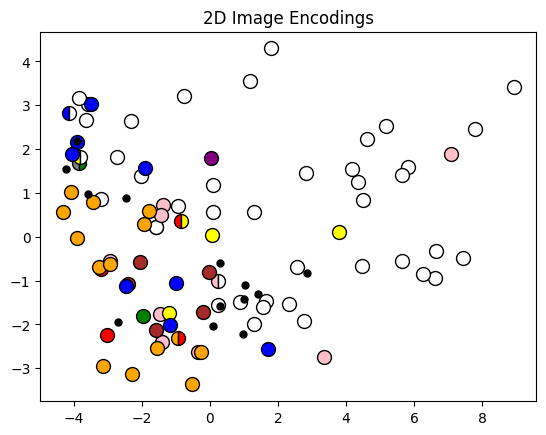

In [410]:
pca = PCA(2)
reduced_encodings = pca.fit_transform(np.stack(rand_sample["encoding"].values))
rand_sample["reduced_encoding"] = reduced_encodings.tolist()

for group in rand_sample.groupby("COLOR", dropna=False):
    if pd.notna(group[0]):
        color = spl_terms.translateColorCode(group[0].split(";"))
        marker_style = {'marker':'o', 'markersize':10, 'color':color[0], 'markeredgecolor':'black'}
        if len(color) > 1:
            marker_style['fillstyle']='left'
            marker_style['markerfacecoloralt']=color[1]
    else:
        marker_style= {'marker':'.', 'markersize':10, 'color':'black'}
    data = np.stack(group[1]["reduced_encodings"].values)
    plt.plot(data[:,0], data[:,1], linestyle="None", **marker_style)
plt.title("2D Image Encodings") 
plt.savefig("./2D_Image_Encodings.png")
# plt.close()

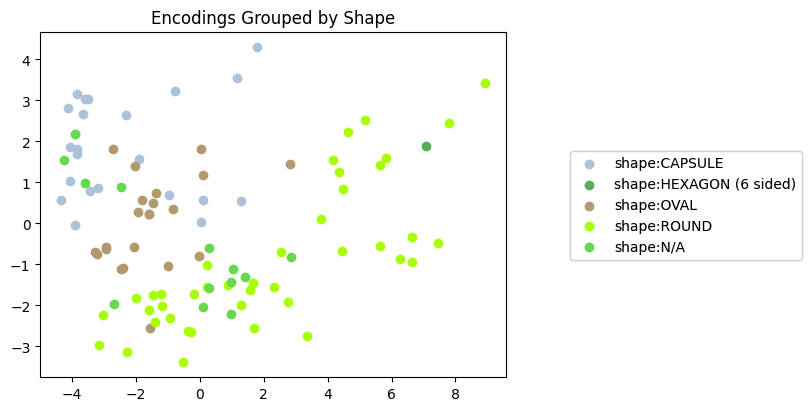

In [ ]:
colors = list(mpl.colors.XKCD_COLORS.keys())
fig,ax = plt.subplot_mosaic([['left', 'right']], layout='constrained', figsize=(8, 4), width_ratios=[5,.5])
for i,group in enumerate(rand_sample.groupby("SHAPE", dropna=False)):
    if pd.notna(group[0]):
        shape = spl_terms.translateShapeCode(group[0])
    else:
        shape = "N/A"
    data = np.stack(group[1]["reduced_encodings"].values)
    ax['left'].scatter(data[:,0], data[:,1], linestyle="None", c=colors[i], label="shape:"+shape)
ax['right'].axis('off')
legend = fig.legend(loc="outside right")
ax['right'].add_artist(legend)
ax['left'].set_title("Encodings Grouped by Shape")
plt.show()
# plt.savefig("./2D_Image_Encodings.png")


Text(0.5, 1.0, 'Encodings Grouped by Shape and Color')

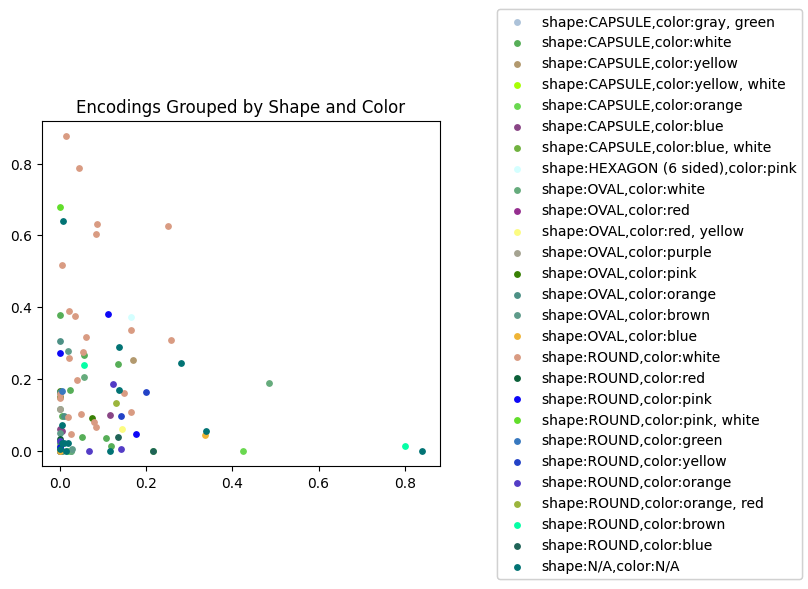

In [438]:
colors = list(mpl.colors.XKCD_COLORS.keys())
fig,ax = plt.subplot_mosaic([['left', 'right']], layout='constrained', figsize=(8, 4), width_ratios=[5,.5])
for i, group in enumerate(rand_sample.groupby(["SHAPE", "COLOR"], dropna=False)):
    if pd.notna(group[0][0]):
        shape = spl_terms.translateShapeCode(group[0][0])
    else:
        shape = "N/A"
    if pd.notna(group[0][1]):
        color = spl_terms.translateColorCode(group[0][1].split(";"))
        if (isinstance(color, list)):
            color = ", ".join(color)
    else:
        color = "N/A"
    label = "shape:" + shape + ",color:" + color
    data = np.stack(group[1]["encoding"].values)
    ax['left'].scatter(data[:, 0], data[:, 1], c=colors[i], s=15, label=label)
ax['right'].axis('off')
legend = fig.legend(loc="outside right")
ax['right'].add_artist(legend)
ax['left'].set_title("Encodings Grouped by Shape and Color")
# plt.savefig("./grouped_encodings_shape_color.png")
# plt.close()

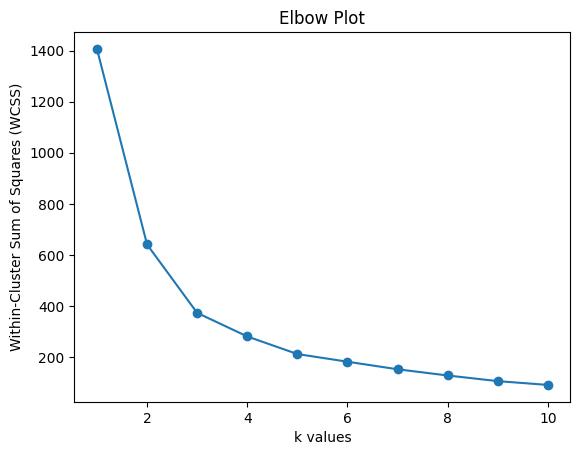

In [431]:
start_k = 1
max_k = 10
wcss=[]
encodings = np.stack(rand_sample["reduced_encoding"].values)
plt.close()
for k in range(start_k, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(encodings)
    center = kmeans.cluster_centers_
    wcss.append(kmeans.inertia_)
    n = len(labels)
    colors = list(mpl.colors.XKCD_COLORS.keys())[0:n]
    plt.scatter(encodings[:, 0], encodings[:, 1], c=list(map(lambda i: colors[i], labels)), s=10)
    plt.scatter(center[:, 0], center[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.title("k=" + str(k))
    plt.savefig("./cluster_plots" + "/k=" + str(k) + ".png")
    plt.close()

plt.plot(np.arange(start_k, max_k+1), wcss, marker="o")
plt.title("Elbow Plot")
plt.xlabel("k values")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.savefig("elbow_plot.png")
plt.show()

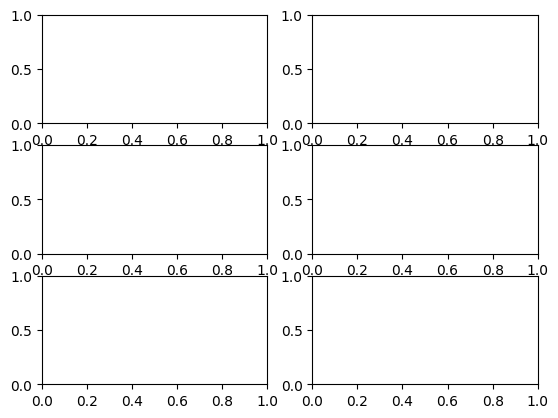

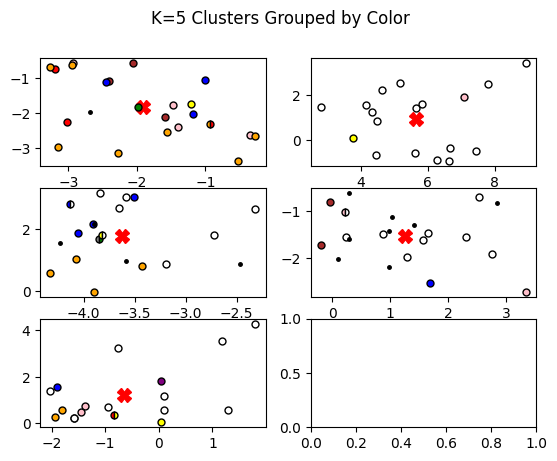

In [539]:
import math
kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(np.stack(rand_sample["reduced_encoding"].values))
center = kmeans.cluster_centers_
rand_sample['center_num'] = labels
nrows = math.ceil(math.sqrt(5))
ncols = math.floor(math.sqrt(5))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False)

for i,group in enumerate(rand_sample.groupby('center_num')):
    center_coord = center[group[0]]
    col = round(i%ncols)
    row = i//ncols
    ax[row][col].plot(center_coord[0], center_coord[1], color='red', markersize=10, marker='X', label='Centroids')
    for color_group in group[1].groupby("COLOR", dropna=False):
        if pd.notna(color_group[0]):
            color = spl_terms.translateColorCode(color_group[0].split(";"))
            marker_style = {'marker':'o', 'markersize':5, 'color':color[0], 'markeredgecolor':'black'}
            if len(color) > 1:
                marker_style['fillstyle']='left'
                marker_style['markerfacecoloralt']=color[1]
        else:
            marker_style= {'marker':'.', 'markersize':5, 'color':'black'}
        data = np.stack(color_group[1]["reduced_encodings"].values)
        ax[row][col].plot(data[:,0], data[:,1], linestyle="None", **marker_style)
fig.suptitle("K=5 Clusters Grouped by Color")
fig.savefig("K=5_Clusters_Color.png")



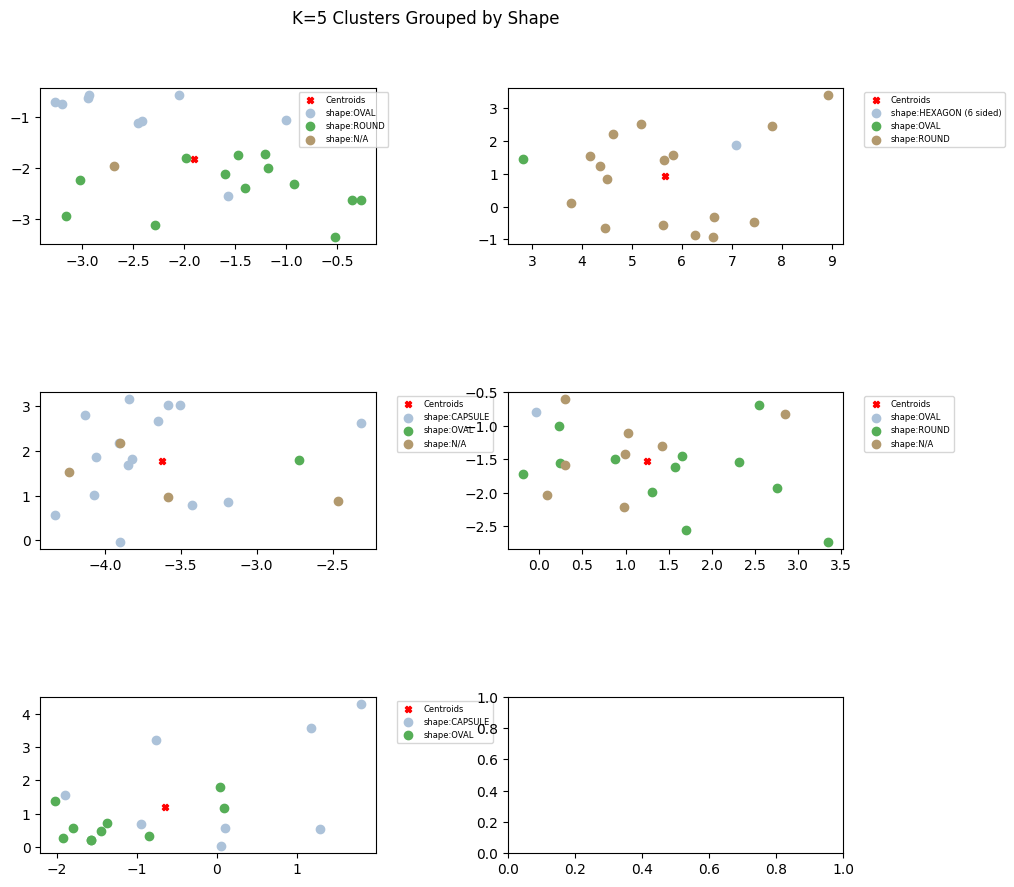

In [586]:
import math
colors = list(mpl.colors.XKCD_COLORS.keys())

kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(np.stack(rand_sample["reduced_encoding"].values))
center = kmeans.cluster_centers_
rand_sample['center_num'] = labels
nrows = math.ceil(math.sqrt(5))
ncols = math.floor(math.sqrt(5))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False)
fig.tight_layout(pad=3)
fig.set_size_inches(10,10)
for i,group in enumerate(rand_sample.groupby('center_num')):
    center_coord = center[group[0]]
    col = round(i%ncols)
    row = i//ncols
    ax[row][col].scatter(center_coord[0], center_coord[1], color='red', s=20, marker='X', label='Centroids')
    for idx, shape_group in enumerate(group[1].groupby("SHAPE", dropna=False)):
        if pd.notna(shape_group[0]):
            shape = spl_terms.translateShapeCode(shape_group[0])
        else:
            shape = "N/A"
        data = np.stack(shape_group[1]["reduced_encodings"].values)
        ax[row][col].scatter(data[:,0], data[:,1], c=colors[idx], label="shape:"+shape)
        ax[row][col].legend(bbox_to_anchor=(1.05, 1), fontsize=6)
fig.suptitle("K=5 Clusters Grouped by Shape")
fig.savefig("K=5_Clusters_Shape.png")
